In [8]:
# 1. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Cargar imágenes
def load_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Definir rutas y cargar los datos de las imágenes
stone_folder = '/content/drive/MyDrive/UTN/IA/Stone/'
normal_folder = '/content/drive/MyDrive/UTN/IA/Normal/'
cyst_folder = '/content/drive/MyDrive/UTN/IA/Cyst/'
tumor_folder = '/content/drive/MyDrive/UTN/IA/Tumor/'

normal_images, normal_labels = load_images(normal_folder, label=0)
stone_images, stone_labels = load_images(stone_folder, label=1)
cyst_images, cyst_labels = load_images(cyst_folder, label=2)
tumor_images, tumor_labels = load_images(tumor_folder, label=3)

X = np.concatenate((stone_images, normal_images, cyst_images, tumor_images), axis=0)
y = np.concatenate((stone_labels, normal_labels, cyst_labels, tumor_labels), axis=0)

# Escalar los valores de los píxeles y preparar las etiquetas
X = X / 255.0
X = X.reshape(-1, 128, 128, 1)
y = to_categorical(y, num_classes=4)

# Dividir en entrenamiento y prueba
x_train_total, x_test, y_train_total, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

# Dividir en entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(x_train_total, y_train_total, test_size=0.1, shuffle=True)


In [3]:
# Función para crear y entrenar modelos
def build_and_train_model(architecture, optimizer, epochs, batch_size):
    input_layer = Input(shape=(128, 128, 1))

    if architecture == 1:
        # Arquitectura 1: MLP básico (Multi-Perceptrón)
        flatten_layer = Flatten()(input_layer)
        hidden_layer_1 = Dense(150, activation='relu')(flatten_layer)
        output_layer = Dense(4, activation='softmax')(hidden_layer_1)

    elif architecture == 2:
        # Arquitectura 2: MLP más profundo
        flatten_layer = Flatten()(input_layer)
        hidden_layer_1 = Dense(200, activation='relu')(flatten_layer)
        hidden_layer_2 = Dense(150, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(100, activation='relu')(hidden_layer_2)
        output_layer = Dense(4, activation='softmax')(hidden_layer_3)

    elif architecture == 3:
        # Arquitectura 3: MLP pequeño (simplificado)
        flatten_layer = Flatten()(input_layer)
        hidden_layer_1 = Dense(100, activation='relu')(flatten_layer)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        output_layer = Dense(4, activation='softmax')(hidden_layer_2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Early stopping callback
    early_stopping_monitor = callbacks.EarlyStopping(monitor='val_loss',
                                                     min_delta=0.01,
                                                     patience=10,
                                                     restore_best_weights=True)

    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping_monitor],
                        verbose=2)

    return model, history


In [4]:
# Función para evaluar el modelo
def evaluate_model(model, history, architecture):
    print(f"\n--- Evaluación del modelo para la Arquitectura {architecture} ---")

    # Datos de entrenamiento y validacion
    print("\n> De los ", len(X), "ejemplos de entrenamiento: ")
    print("            se usan ", len(x_train), "ejemplos para entrenar ")
    print("            y ", len(x_val), "ejemplos para validar.")

    # Evaluar en los datos de prueba
    test_loss, test_accuracy = model.evaluate(x_val, y_val, verbose=0)
    print(f"Precisión del modelo en test: {test_accuracy}")

    # Graficar el progreso del error (Loss)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Arquitectura {architecture} - Pérdida durante el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

    # Graficar la precisión
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title(f'Arquitectura {architecture} - Precisión durante el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()

    # Predicciones del modelo
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # 1. Matriz de confusión
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

    # 2. Exactitud (Accuracy)
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    print(f'Exactitud (Accuracy): {accuracy:.2f}')

    # 3. Precisión (Precision) para cada clase
    precision = precision_score(y_true_classes, y_pred_classes, average=None)
    print(f'Precisión por clase: {precision}')

    # 4. Recuperación (Recall) para cada clase
    recall = recall_score(y_true_classes, y_pred_classes, average=None)
    print(f'Recuperación por clase: {recall}')

    # 5. Reporte de clasificación completo
    print("Reporte de clasificación:")
    print(classification_report(y_true_classes, y_pred_classes))

    # Extra: Precisión, Recall y F1-score promediados
    precision_avg = precision_score(y_true_classes, y_pred_classes, average='macro')
    recall_avg = recall_score(y_true_classes, y_pred_classes, average='macro')

    print(f'Precisión Promedio (Macro): {precision_avg:.2f}')
    print(f'Recuperación Promedio (Macro): {recall_avg:.2f}')


Epoch 1/30
263/263 - 7s - 25ms/step - accuracy: 0.7951 - loss: 0.6211 - val_accuracy: 0.9208 - val_loss: 0.3059
Epoch 2/30
263/263 - 6s - 24ms/step - accuracy: 0.9660 - loss: 0.1985 - val_accuracy: 0.9668 - val_loss: 0.1665
Epoch 3/30
263/263 - 12s - 47ms/step - accuracy: 0.9902 - loss: 0.0986 - val_accuracy: 0.9946 - val_loss: 0.0912
Epoch 4/30
263/263 - 5s - 20ms/step - accuracy: 0.9967 - loss: 0.0596 - val_accuracy: 0.9957 - val_loss: 0.0566
Epoch 5/30
263/263 - 9s - 35ms/step - accuracy: 0.9983 - loss: 0.0411 - val_accuracy: 0.9968 - val_loss: 0.0438
Epoch 6/30
263/263 - 4s - 17ms/step - accuracy: 0.9988 - loss: 0.0306 - val_accuracy: 0.9657 - val_loss: 0.0934
Epoch 7/30
263/263 - 4s - 14ms/step - accuracy: 0.9994 - loss: 0.0240 - val_accuracy: 0.9989 - val_loss: 0.0275
Epoch 8/30
263/263 - 6s - 22ms/step - accuracy: 0.9998 - loss: 0.0192 - val_accuracy: 0.9989 - val_loss: 0.0234
Epoch 9/30
263/263 - 4s - 16ms/step - accuracy: 1.0000 - loss: 0.0159 - val_accuracy: 0.9989 - val_loss

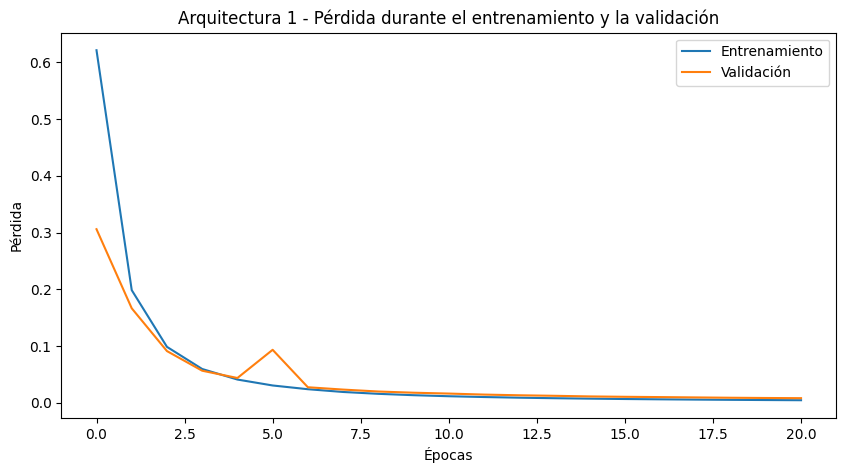

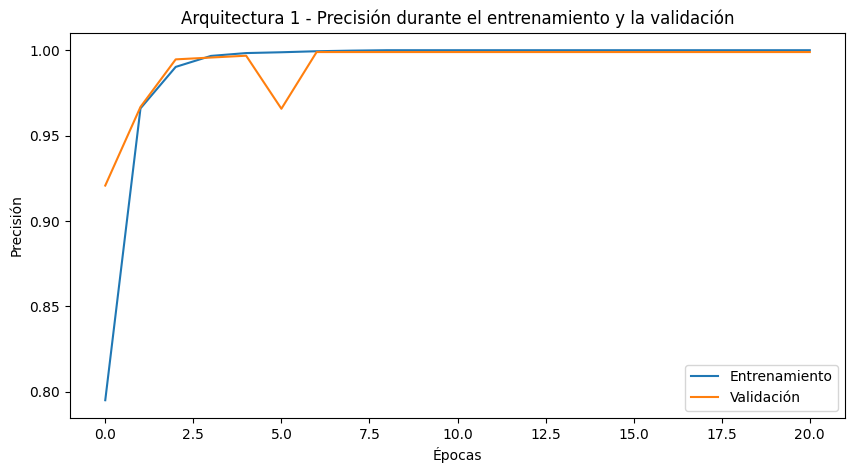

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


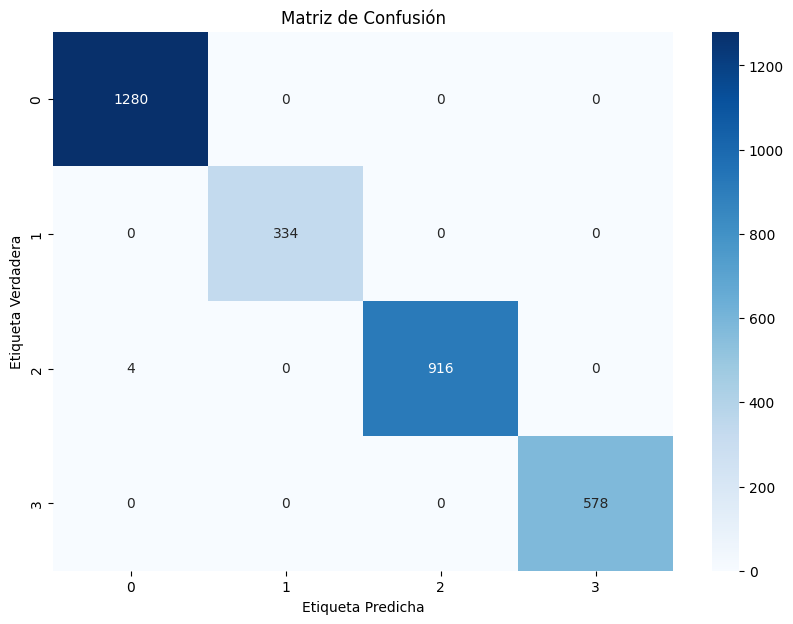

Exactitud (Accuracy): 1.00
Precisión por clase: [0.99688474 1.         1.         1.        ]
Recuperación por clase: [1.         1.         0.99565217 1.        ]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1280
           1       1.00      1.00      1.00       334
           2       1.00      1.00      1.00       920
           3       1.00      1.00      1.00       578

    accuracy                           1.00      3112
   macro avg       1.00      1.00      1.00      3112
weighted avg       1.00      1.00      1.00      3112

Precisión Promedio (Macro): 1.00
Recuperación Promedio (Macro): 1.00


In [5]:

# Entrenar y evaluar tres modelos con diferentes arquitecturas y parámetros
epochs = 30
batch_size = 32

# Entrenamiento para la Arquitectura 1
model_1, history_1 = build_and_train_model(architecture=1, optimizer=SGD(learning_rate=0.01), epochs=epochs, batch_size=batch_size)
evaluate_model(model_1, history_1, architecture=1)

Epoch 1/30
263/263 - 6s - 23ms/step - accuracy: 0.7420 - loss: 0.7024 - val_accuracy: 0.8897 - val_loss: 0.3077
Epoch 2/30
263/263 - 13s - 49ms/step - accuracy: 0.9696 - loss: 0.1524 - val_accuracy: 0.9904 - val_loss: 0.0726
Epoch 3/30
263/263 - 6s - 24ms/step - accuracy: 0.9955 - loss: 0.0453 - val_accuracy: 0.9914 - val_loss: 0.0473
Epoch 4/30
263/263 - 7s - 25ms/step - accuracy: 0.9943 - loss: 0.0534 - val_accuracy: 0.9989 - val_loss: 0.0215
Epoch 5/30
263/263 - 5s - 19ms/step - accuracy: 0.9998 - loss: 0.0127 - val_accuracy: 0.9989 - val_loss: 0.0139
Epoch 6/30
263/263 - 4s - 17ms/step - accuracy: 0.9999 - loss: 0.0080 - val_accuracy: 0.9989 - val_loss: 0.0104
Epoch 7/30
263/263 - 7s - 27ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9989 - val_loss: 0.0088
Epoch 8/30
263/263 - 8s - 30ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.9989 - val_loss: 0.0075
Epoch 9/30
263/263 - 8s - 29ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9989 - val_loss

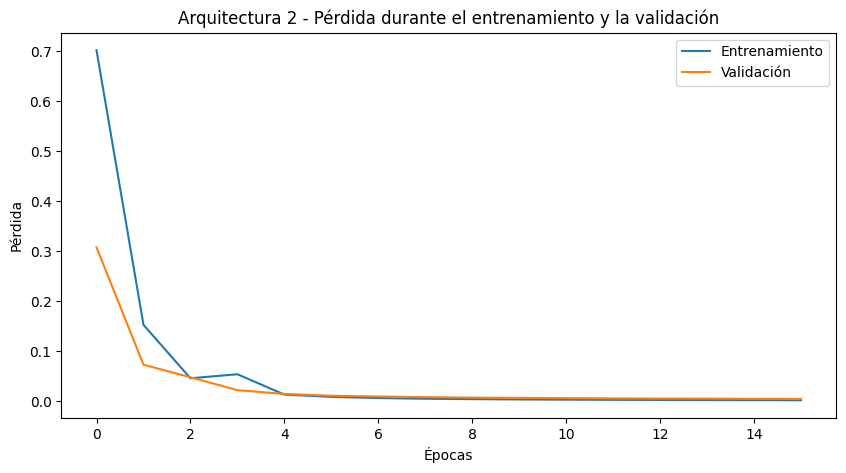

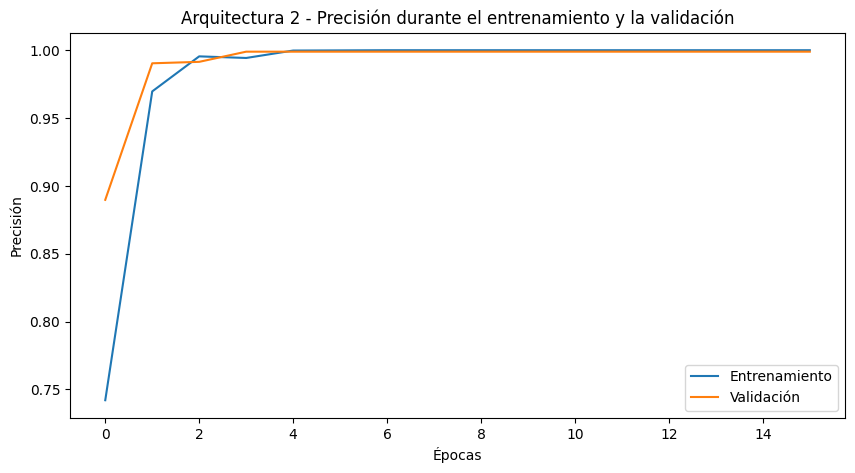

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


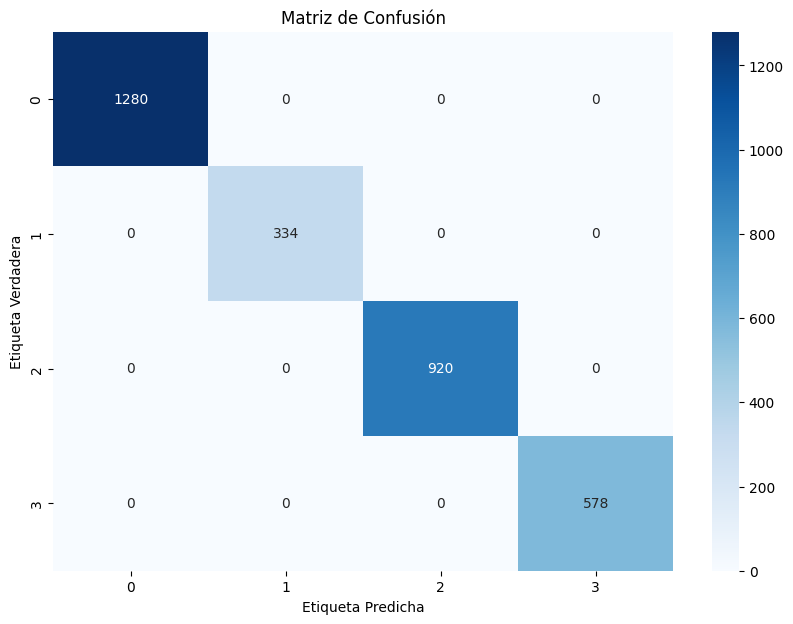

Exactitud (Accuracy): 1.00
Precisión por clase: [1. 1. 1. 1.]
Recuperación por clase: [1. 1. 1. 1.]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1280
           1       1.00      1.00      1.00       334
           2       1.00      1.00      1.00       920
           3       1.00      1.00      1.00       578

    accuracy                           1.00      3112
   macro avg       1.00      1.00      1.00      3112
weighted avg       1.00      1.00      1.00      3112

Precisión Promedio (Macro): 1.00
Recuperación Promedio (Macro): 1.00


In [6]:
# Entrenamiento para la Arquitectura 2
model_2, history_2 = build_and_train_model(architecture=2, optimizer=SGD(learning_rate=0.01), epochs=epochs, batch_size=batch_size)
evaluate_model(model_2, history_2, architecture=2)

Epoch 1/30
263/263 - 7s - 25ms/step - accuracy: 0.9112 - loss: 0.2651 - val_accuracy: 0.9979 - val_loss: 0.0238
Epoch 2/30
263/263 - 11s - 42ms/step - accuracy: 0.9987 - loss: 0.0124 - val_accuracy: 0.9989 - val_loss: 0.0089
Epoch 3/30
263/263 - 5s - 20ms/step - accuracy: 0.9963 - loss: 0.0131 - val_accuracy: 0.9700 - val_loss: 0.0926
Epoch 4/30
263/263 - 7s - 26ms/step - accuracy: 0.9888 - loss: 0.0368 - val_accuracy: 0.9989 - val_loss: 0.0075
Epoch 5/30
263/263 - 6s - 22ms/step - accuracy: 1.0000 - loss: 5.6375e-04 - val_accuracy: 0.9989 - val_loss: 0.0072
Epoch 6/30
263/263 - 6s - 21ms/step - accuracy: 1.0000 - loss: 3.2660e-04 - val_accuracy: 0.9989 - val_loss: 0.0070
Epoch 7/30
263/263 - 15s - 59ms/step - accuracy: 1.0000 - loss: 2.2789e-04 - val_accuracy: 0.9989 - val_loss: 0.0072
Epoch 8/30
263/263 - 6s - 24ms/step - accuracy: 1.0000 - loss: 1.7070e-04 - val_accuracy: 0.9989 - val_loss: 0.0071
Epoch 9/30
263/263 - 10s - 38ms/step - accuracy: 1.0000 - loss: 1.3200e-04 - val_accur

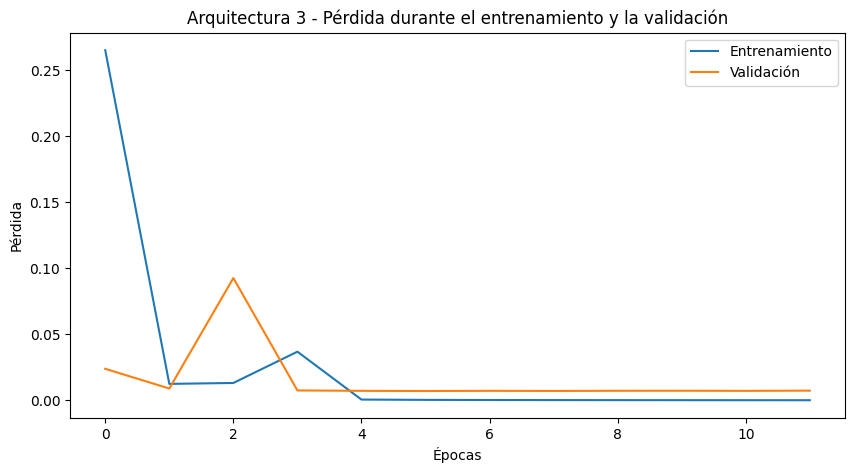

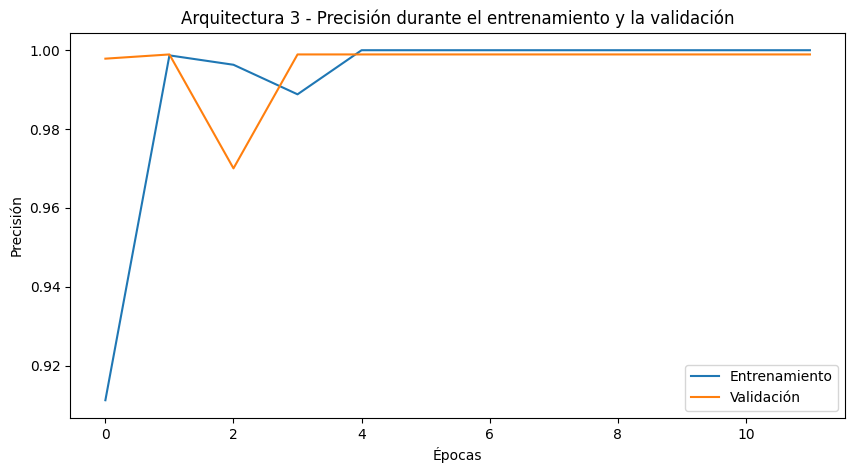

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


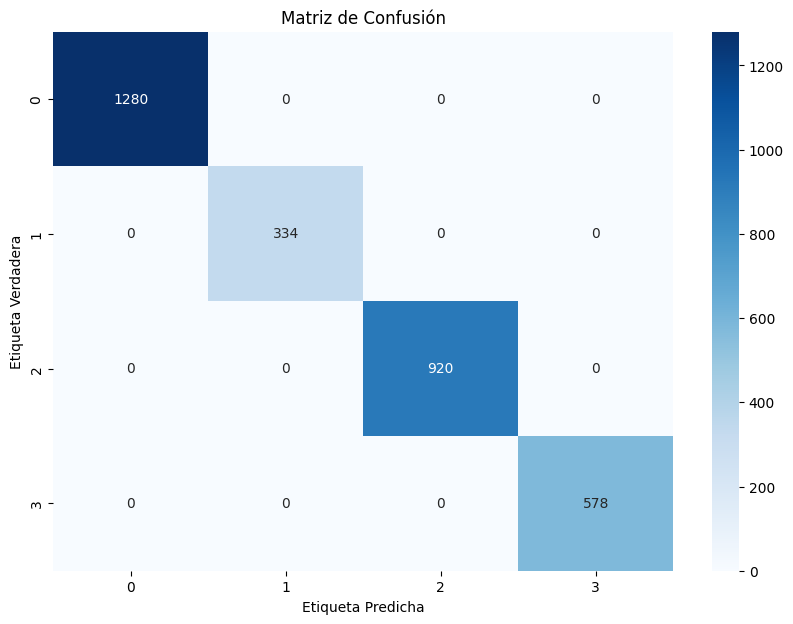

Exactitud (Accuracy): 1.00
Precisión por clase: [1. 1. 1. 1.]
Recuperación por clase: [1. 1. 1. 1.]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1280
           1       1.00      1.00      1.00       334
           2       1.00      1.00      1.00       920
           3       1.00      1.00      1.00       578

    accuracy                           1.00      3112
   macro avg       1.00      1.00      1.00      3112
weighted avg       1.00      1.00      1.00      3112

Precisión Promedio (Macro): 1.00
Recuperación Promedio (Macro): 1.00


In [7]:
# Entrenamiento para la Arquitectura 3
model_3, history_3 = build_and_train_model(architecture=3, optimizer=Adam(learning_rate=0.001), epochs=epochs, batch_size=batch_size)
evaluate_model(model_3, history_3, architecture=3)